# EE 511 Assignment 2 - PartII
University of Washington<br>
Code by John Ragland and Doruk Arisoy<br>
Winter 2021

In [1]:
import tools
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

# Some magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## \[Step 3\] Load training, validation and testing data

In [2]:
train, valid, test = tools.load_data()

## \[Step 4\] One variable least squares linear regression 

In [3]:
area_label = 'Gr Liv Area'
price_label = 'SalePrice'

area_train = train[area_label].to_numpy()
area_valid = valid[area_label].to_numpy()
area_test = test[area_label].to_numpy()
price_train = train[price_label].to_numpy()
price_valid = valid[price_label].to_numpy()
price_test = test[price_label].to_numpy()

In [4]:
weights = tools.calculate_OLS(area_train, price_train)

Text(0.5, 1.0, 'Sale Price vs. Gr Liv Area - Linear Regression')

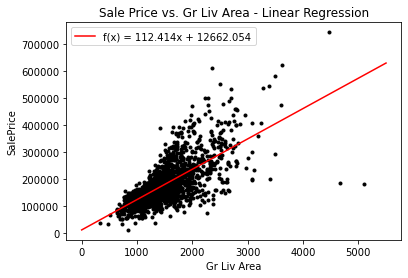

In [14]:
x = np.linspace(0, 5500, 100)
y = weights[0] * x + weights[1]

plt.xlabel(area_label)
plt.ylabel(price_label)
plt.plot(area_train, price_train, '.', color='black')
plt.plot(x, y, '-r', label="f(x) = %.3fx + %.3f" % (weights[0], weights[1]))
plt.legend()
plt.title('Sale Price vs. Gr Liv Area - Linear Regression')

In [63]:
price_predicted = tools.predict(np.array(area_valid), weights)
print("RMSE = $%.2f" % (tools.rmse(price_valid, price_predicted)))

RMSE = $56299.05


## \[Step 5\] Adding more features to the simple model

In [64]:
train_without_price = train.drop(price_label, 1).to_numpy()
weights = tools.calculate_OLS(train_without_price, price_train)

In [65]:
valid_without_price = valid.drop(price_label, 1).to_numpy()
price_predicted = tools.predict(valid_without_price, weights)
print("RMSE = $%.2f" % (tools.rmse(price_valid, price_predicted)))

RMSE = $26191.88


## \[Step 6\] Adding L1 regularization

## Debugging

In [2]:
# Understanding Labels One Hot Vector Encoding
train, valid, test = tools.load_data()


KeyError: 'Lot Shape'

In [66]:
from sklearn.preprocessing import OneHotEncoder

 

0       1
1       0
4       1
5       1
6       0
       ..
2921    1
2924    0
2925    1
2926    1
2929    0
Name: Lot Shape, Length: 1758, dtype: uint8